# Solving Lane-Emden via Shooting


We'll use 4th order RK integration and we'll integrate both inward from the surface and outward from the center and meet at some point in the middle, $\xi_\mathrm{fit}$.

We rewrite our system by defining:

\begin{align*}
y &= \theta \\
z &= d\theta/d\xi = dy/d\xi
\end{align*}

then our system is:

\begin{align*}
\frac{dy}{d\xi} &= z \\
\frac{dz}{d\xi} &= -y^n - \frac{2}{\xi} z
\end{align*}

At $\xi = 0$, the righthand side of $dz/d\xi$ looks like it blows up, but in the limit $\xi \rightarrow 0$, the solution takes the form:

$$\theta(\xi) = 1 - \frac{1}{6}\xi^2 + \frac{n}{120} \xi^4 + \ldots$$

which allows us to simply the $dz/d\xi$ near $\xi = 0$ as:

$$\frac{dz}{d\xi} \approx -\frac{1}{3}$$

We're going to integrate outward from the center and inward from the surface and meet in the middle.

At the center, our boundary conditions are:

* $y(0) = 1$
* $z(0) = 0$

and at the surface, $\xi_s$, they are:

* $y(\xi_s) = 0$
* $z(\xi_s) = \eta$

Initially, we don't know either $\eta$ or $\xi_s$.

Our algorithm will proceed as follows:

* Take an initial guess for $\eta$ and $\xi_s$.  Pick $\xi_f = \xi_s/2$.

* Integrate from the center outward to the fit point, $\xi_f$, getting the solution: $y_\mathrm{out}(\xi_f)$, $z_\mathrm{out}(\xi_f)$.

* Integrate from the surface (starting at the guess $\xi_s$ inward to the fit point, getting the
solution $y_\mathrm{in}(\xi_f)$, $z_\mathrm{in}(\xi_f)$

* Constrain the solution to match at the fit point by finding the zero of:

  \begin{align*}
  Y(\eta, \xi_s) &\equiv y_\mathrm{in}(\xi_f) - y_\mathrm{out}(\xi_f) = 0 \\
  Z(\eta, \xi_s) &\equiv z_\mathrm{in}(\xi_f) - z_\mathrm{out}(\xi_f) = 0
  \end{align*}
  
  we will do this via the secant method.  This will yield a new guess for $\eta$ and $\xi_s$.
  
* Iterate over this procedure until the $\eta$ and $\xi_s$ converge.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
def rhs(xi, H, n):
    
    y = H[0]
    z = H[1]

    f0 = z

    if xi == 0.0:
        f1 = 2.0/3.0 - y**n
    else:
        f1 = -2.0*z/xi - y**n

    return np.array([f0, f1])

We'll use SciPy's implementation of 4th order Runge-Kutta here

In [3]:
def le_integrate(xi_start, xi_end, H0, n):

    sol = solve_ivp(rhs, (xi_start, xi_end), H0,
                    method="RK45", rtol=1.e-8, atol=1.e-8, args=(n,))

    xi = sol.t
    y = sol.y[0, :]
    z = sol.y[1, :]

    return xi, y, z

Now, we still need to understand how to solve for 2 roots from 2 equations (so far, we've only done the scalar case).

Let's Taylor expand our functions $Y$ and $Z$:

\begin{align*}
Y(\eta +\Delta \eta, \xi_s + \Delta \xi_s) &= Y(\eta, \xi_s) + \frac{\partial Y}{\partial \eta} \Delta \eta + \frac{\partial Y}{\partial \xi_s} \Delta \xi_s \sim 0 \\
Z(\eta +\Delta \eta, \xi_s + \Delta \xi_s) &= Z(\eta, \xi_s) + \frac{\partial Z}{\partial \eta} \Delta \eta + \frac{\partial Z}{\partial \xi_s} \Delta \xi_s \sim 0 
\end{align*}

We want to solve for the corrections, $\Delta \eta$ and $\Delta \xi_s$ that zero this&mdash;this is Newton's method, but now for a system of equations.

We can solve the first equation for $\Delta \eta$:

$$\Delta \eta = \left ( \frac{\partial Y}{\partial\eta} \right )^{-1} \left [ \frac{\partial Y}{\partial \xi_s} \Delta \xi_s - Y \right ]$$

and then substitute this into the second equation and solve for $\Delta \xi_s$:

$$\Delta \xi_s = \frac{-Z + \frac{\partial Z}{\partial \eta} \left ( \frac{\partial Y}{\partial \eta} \right )^{-1} Y}{\frac{\partial Z}{\partial \xi_s} + \frac{\partial Z}{\partial \eta} \left ( \frac{\partial Y}{\partial \eta} \right)^{-1} \frac{\partial Y}{\partial \xi_s}}$$

We still need the derivatives, which we will compute via differencing.

For systems with more than 2 equations and 2 unknowns, it becomes tedious to analytically solve for the corrections.  Instead, as we'll see shortly, we can express this as a linear system and solve for the corrections using numerical linear algebra methods.

In [21]:
def solve_le(n):

    # initial guesses for the unknowns -- if we aren't careful with the
    # guess at the outer boundary, we can get 2 roots.  Here we know that
    # n = 1 has xi_s = pi

    if n > 2.0:
        xi_s = 8.0
    else:
        xi_s = np.pi

    eta = -0.01

    # for numerical differentiation
    eps = 1.e-8

    # main iteration loop
    converged = False
    while not converged:

        # fitting point
        xi_fit = xi_s / 2.0

        # baseline integration

        # outward from the center
        xi_out, y_out, z_out = le_integrate(0.0, xi_fit, [1.0, 0.0], n)

        # inward from xi_s
        xi_in, y_in, z_in = le_integrate(xi_s, xi_fit, [0.0, eta], n)

        # the two functions we want to zero
        Ybase = y_in[-1] - y_out[-1]
        Zbase = z_in[-1] - z_out[-1]

        # now do eta + eps*eta, xi_s
        # inward from xi_s
        H0 = np.array([0.0, eta*(1.0+eps)])
        xi_in, y_in, z_in = le_integrate(xi_s, xi_fit, [0.0, eta * (1.0 + eps)], n)

        Ya = y_in[-1] - y_out[-1]
        Za = z_in[-1] - z_out[-1]

        # our derivatives
        dYdeta = (Ya - Ybase) / (eta * eps)
        dZdeta = (Za - Zbase) / (eta * eps)

        # now do alpha, xi_s + eps*xi_s
        # inward from xi_s
        xi_in, y_in, z_in = le_integrate(xi_s  * (1.0 + eps), xi_fit, [0.0, eta], n)

        Yxi = y_in[-1] - y_out[-1]
        Zxi = z_in[-1] - z_out[-1]

        # our derivatives
        dYdxi_s = (Yxi - Ybase) / (xi_s * eps)
        dZdxi_s = (Zxi - Zbase) / (xi_s * eps)

        # compute the correction for our two parameters
        dxi_s = - (Zbase - dZdeta * Ybase / dYdeta) / \
                    (dZdxi_s - dZdeta * dYdxi_s / dYdeta)

        deta = -(Ybase + dYdxi_s * dxi_s) / dYdeta

        # limit the changes per iteration
        deta = min(abs(deta), 0.1 * abs(eta)) * np.copysign(1.0, deta)
        dxi_s = min(abs(dxi_s), 0.1 * abs(xi_s)) * np.copysign(1.0, dxi_s)
                    
        print(f"corrections:  {deta:13.10f}, {dxi_s:13.10f}")
        
        eta += deta
        xi_s += dxi_s

        if abs(deta) < eps * abs(eta) and abs(dxi_s) < eps * abs(xi_s):
            converged = True
            
    return xi_in, y_in, z_in, xi_out, y_out, z_out

In [22]:
n = 3
xi_in, y_in, z_in, xi_out, y_out, z_out = solve_le(n)

corrections:  -0.0010000000, -0.8000000000
corrections:  -0.0011000000,  0.1041147613
corrections:  -0.0012100000, -0.4023129572
corrections:  -0.0013310000,  0.6901801804
corrections:  -0.0014641000, -0.7591981985
corrections:  -0.0016105100,  0.6832783786
corrections:  -0.0017715610, -0.7516062165
corrections:  -0.0019487171,  0.6764455948
corrections:  -0.0021435888, -0.7440901543
corrections:  -0.0023579477,  0.6696811389
corrections:  -0.0025937425, -0.6416950043
corrections:  -0.0028531167,  0.5277799831
corrections:  -0.0031384284, -0.4366093478
corrections:  -0.0034522712,  0.1755125576
corrections:  -0.0037974983, -0.0987624438
corrections:  -0.0006486268,  0.0046186327
corrections:  -0.0000086425, -0.0004880733
corrections:  -0.0000000003,  0.0000000612


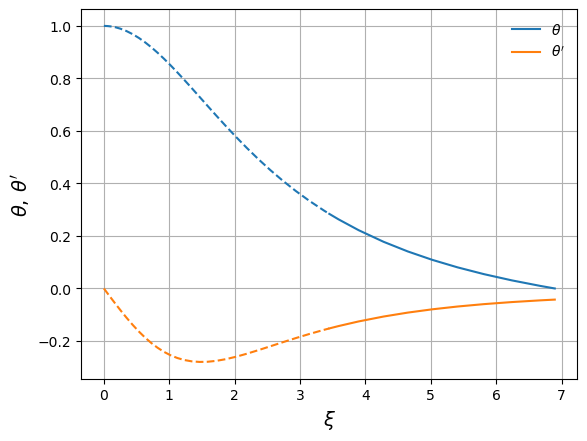

In [23]:
fig, ax = plt.subplots()

ax.plot(xi_in, y_in, color="C0", label=r"$\theta$")
ax.plot(xi_out, y_out, color="C0", ls="--")

ax.plot(xi_in, z_in, color="C1", label=r"$\theta'$")
ax.plot(xi_out, z_out, color="C1", ls="--")

ax.set_xlabel(r"$\xi$", fontsize=14)
ax.set_ylabel(r"$\theta,\, \theta'$", fontsize=14)

ax.legend(frameon=False, loc="best")
ax.grid()

Now we can get the surface of the polytrope, $\xi_1$

In [16]:
xi1 = xi_in[0]
xi1

6.896848900785904

and $\theta^\prime$ at the surface:

In [17]:
dthetadxi_1 = z_in[0]

A common quantity needed in finding physical values is $-\xi_1^2 \theta^\prime |_{\xi=\xi_1}$

In [18]:
-xi1**2 * dthetadxi_1

2.018235801821596